In [2]:
import os, sys
sys.path.append(os.getcwd()+"/../..")
sys.path.append(os.getcwd()+"/..")
import pandas as pd
from bit_flip_experiments import is_target_qs, backends_w_embs
import seaborn as sns
from utils import load_algorithms_file, Precision
from game import serialize_algorithms, dump_algorithms
from noise import get_ibm_noise_model


Consider a graph with $n$ vertices. 
This graph can have at most $n*(n-1)$ edges.

We compute the density of vertices in the topology of QPUs:
$$
 d =  \frac{\text{actual num. edges}}{n*(n-1)}
$$

In [3]:
Precision.PRECISION = 5
Precision.update_threshold()
num_qubits_row = []
ratios_row = []
result = dict()
for backend in backends_w_embs:
    noise_model = get_ibm_noise_model(backend)
    n = noise_model.get_num_qubits()
    ratio = round(
              noise_model.get_num_couplers()/(n*(n-1)) , 3)
    if n not in result.keys():
        result[n] = set()
    result[n].add(ratio)
    
for (key, value) in result.items():
    for v in value:
        num_qubits_row.append(key)
        ratios_row.append(v)
        
pd.DataFrame({"num. qubits": num_qubits_row, "d": ratios_row})

,num. qubits,d
0,5,0.400
1,5,0.600
2,5,0.300
3,7,0.286
4,14,0.220
5,16,0.133
6,20,0.184
7,20,0.121
8,27,0.080
9,28,0.079


In [9]:
print("statistics of edges-density grouped by number of qubits in a quantum hardware".upper())
print()
df = pd.DataFrame({"num. qubits": num_qubits_row, "d": ratios_row})
df.groupby(["num. qubits"]).describe()

STATISTICS OF EDGES-DENSITY GROUPED BY NUMBER OF QUBITS IN A QUANTUM HARDWARE



d                                                            
            count      mean       std    min      25%     50%      75%    max
num. qubits                                                                  
5             3.0  0.433333  0.152753  0.300  0.35000  0.4000  0.50000  0.600
7             1.0  0.286000       NaN  0.286  0.28600  0.2860  0.28600  0.286
14            1.0  0.220000       NaN  0.220  0.22000  0.2200  0.22000  0.220
16            1.0  0.133000       NaN  0.133  0.13300  0.1330  0.13300  0.133
20            2.0  0.152500  0.044548  0.121  0.13675  0.1525  0.16825  0.184
27            1.0  0.080000       NaN  0.080  0.08000  0.0800  0.08000  0.080
28            1.0  0.079000       NaN  0.079  0.07900  0.0790  0.07900  0.079
53            1.0  0.042000       NaN  0.042  0.04200  0.0420  0.04200  0.042
65            1.0  0.035000       NaN  0.035  0.03500  0.0350  0.03500  0.035
127           1.0  0.018000       NaN  0.018  0.01800  0.0180  0.01800  0.018

Suppose we deal with the following possible instructions

$$
\{CX, H, S, \texttt{MEAS} \}
$$

if only $(d*100)\%$ (ratio) of those edges exist then there are 
$$
\text{num. CX instructions} = d*n*(n-1)
$$

While for each qubit we can have an $H,S$ or $\texttt{MEAS}$ instruction. Therefore, the total number of instructions is
$$
\text{total instructions} = d*n*(n-1) + 3*n
$$


In [11]:
# from math import floor
# all_instructions_needed = []
# for r in ratios_row:
#     print("ratio:", r)
#     for num_qubits in range(2, 9):
#         num_instructions_needed = max(round(num_qubits*(num_qubits-1)*r), 1) + round(3*num_qubits*0.4)
#         all_instructions_needed.append(num_instructions_needed)
#         print(num_qubits, max(
#                     round(i*(i-1)*r), 1) 
#                   + round(3*i*0.4))
#     print("**********")
#     print()

Given:
- horizon k 
- number of instructions I

The number of states we can reach in the belief graph is 
$$
S = (I*2)^k
$$

because we consider only single qubit measurements.

---------

The number of policies to evaluate is 

$$
\mathcal{O}(I*S)
$$

### What can we do in at most 3 hours?

- Suppose $10^9$ operations can be performed in a second.
- In 3 hours there are ~$10^4$ seconds
- Therefore, in 3 hours we can perform ~ $10^4*10^9 = 10^{13}$ operations
- assume evaluating a policy is one of such operation

In [34]:
from math import log10
def get_num_policies(I, k):
    return I**k

horizons = []
count_ins = []
times = []
feasible = []
for num_instructions in range(1, 11):
    for k in range(1, 11):
        val  = get_num_policies(num_instructions, k)
        horizons.append(k)
        count_ins.append(num_instructions)
        times.append(val/(10**9)) # value in seconds
        if val <= (10**13): # if the number of policies we have to 
                            # evaluate is less than the number of ops perfomed in 3 hours
            feasible.append(True)
        else:
            feasible.append(False)
df = pd.DataFrame({"horizon": horizons, "num_instructions": count_ins, "time(hours)": times, "less than 3 hours?": feasible})

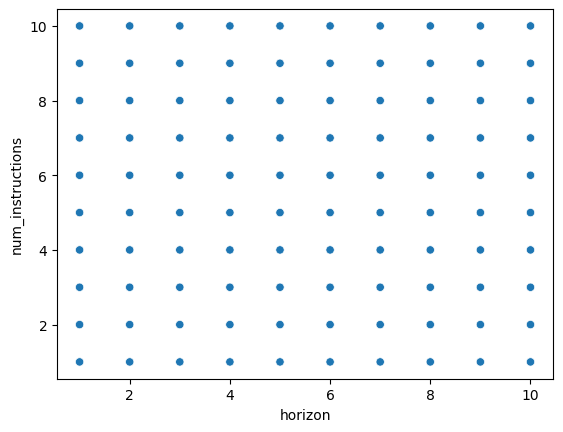

In [35]:
s = sns.scatterplot(df, x ="horizon", y="num_instructions",  hue="less than 3 hours?", legend=False)


Each dot represent an instance of number of instruction an horizon that we could in theory explore and that would take less than 3 hours.